In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')
import scipy.io as sio
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from pyearth import Earth, export
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "/Users/xizheng/Documents/florin/respiration/K1/K1_20191226_r0_traces.mat"
Traces = sio.loadmat(filepath)['Traces']

In [3]:
def process_resp(resp):
    windowsize = 15
    resp = resp - np.median(resp)
    resp = -resp
    resp = np.convolve(resp, np.ones(windowsize), 'same') / windowsize
    resp_pks_2, _ = find_peaks(-resp, prominence=0.3, height=0.2, distance=10)
    
    return resp, resp_pks_2

In [4]:
def lever_fit_pyearth(lever):
    x = np.arange(len(lever))
    #Fit an Earth model
    model = Earth(thresh=1e-5, minspan=30, penalty=10.0, check_every=1)
    model.fit(x,lever)
    
    y_hat = model.predict(x)
    
    vel = np.gradient(y_hat)
    acc = np.gradient(vel)
    peaks, _ = find_peaks(np.abs(acc), height=0.003, distance=20)
    
    return model, peaks

In [5]:
def analyze(Traces, idx):
    
#     print("start analyzing", idx)
    
    # get data
    resp = Traces[0,0]['Sniffs'][0,idx].flatten()
    trial_on = Traces[0,0]['Trial'][0,idx].flatten()!=0
    if len(resp) == 0:
        print("skipping trial", idx)
        return None
    
    # select region to study
#     trial_off_idx = np.where(trial_on!=0)[0][-1]+1
    trial_off_idx = len(trial_on)
    trial_on = trial_on[:trial_off_idx]
    
    # resp
    resp, resp_pks_2 = process_resp(resp[:trial_off_idx])
    
    # lever
    lever = Traces[0,0]['Lever'][0,idx].flatten()
    lever = savgol_filter(lever, 25, 4)
    lever = lever[:trial_off_idx]
    # earth model
#     model, peaks = lever_fit_pyearth(lever)

    # peaks in lever
    pks1, _ = find_peaks(lever, prominence=0.01, distance=5)
    pks2, _ = find_peaks(-lever, prominence=0.01, distance=5)
    peaks = np.concatenate((pks1, pks2))
    peaks = np.sort(peaks)
#     print(peaks)
    
    movement = np.zeros(len(peaks)-1)
    for i in range(len(peaks)-1):
        movement[i] = abs(lever[peaks[i+1]] - lever[peaks[i]])
    movement_signal = np.zeros(len(lever))
    movement_signal[peaks[:-1]] = movement
    large_thresh = 1
    movement_signal = movement_signal > large_thresh
    
    licks = Traces[0,0]['Licks'][0,idx].flatten()
#     movement_signal = licks
    
    # combine sniff and move
    sniff_intervals = np.diff(resp_pks_2)
    
    sniff_trial_first = np.empty((len(resp_pks_2)-1, 600))
    sniff_trial_first[:] = np.nan
    sniff_trial_after = np.empty((len(resp_pks_2)-1, 600))
    sniff_trial_after[:] = np.nan
    for start_idx in range(len(resp_pks_2)-1):
        if trial_on[resp_pks_2[start_idx]] != 0:
            if resp_pks_2[start_idx] <= 1000:
                sniff_trial_first[start_idx,:sniff_intervals[start_idx]+50] = movement_signal[resp_pks_2[start_idx]-50:resp_pks_2[start_idx+1]]
            else:
                sniff_trial_after[start_idx,:sniff_intervals[start_idx]+50] = movement_signal[resp_pks_2[start_idx]-50:resp_pks_2[start_idx+1]]
    
    # sort
    sniff_trial_first_lengths = np.sum(~np.isnan(sniff_trial_first), 1)
    a_order_trial_first = np.argsort(sniff_trial_first_lengths)[::-1]
    sniff_trial_first_sorted = sniff_trial_first[a_order_trial_first,:]
    sniff_trial_first_sorted_valid = sniff_trial_first_sorted[~np.isnan(sniff_trial_first_sorted).all(axis=1),:]
#     sniff_trial_first_sorted_valid = sniff_trial_first[~np.isnan(sniff_trial_first).all(axis=1),:]
    
    sniff_trial_after_lengths = np.sum(~np.isnan(sniff_trial_after), 1)
    a_order_trial_after = np.argsort(sniff_trial_after_lengths)[::-1]
    sniff_trial_after_sorted = sniff_trial_after[a_order_trial_after,:]
    sniff_trial_after_sorted_valid = sniff_trial_after_sorted[~np.isnan(sniff_trial_after_sorted).all(axis=1),:]    
#     sniff_trial_after_sorted_valid = sniff_trial_after[~np.isnan(sniff_trial_after).all(axis=1),:]
    
#     print(f"trial {idx} has {sniff_trial_first_sorted_valid.shape[0]} sniffs in the 1 second")
#     print(f"trial {idx} has {sniff_trial_after_sorted_valid.shape[0]} sniffs after the 1 second")
    
#     plt.figure(figsize=(12,8))
#     plt.plot(lever)
# #     plt.plot(peaks, lever[peaks], 'ob')
#     plt.plot(movement_signal)
#     plt.plot(np.where(movement_signal!=0)[0], lever[np.where(movement_signal!=0)[0]], 'or')
#     for i in range(len(resp_pks_2)):
#         plt.axvline(resp_pks_2[i], color='k', linewidth=0.5)
#     plt.plot(5*trial_on)
#     plt.axvline(1000, color='g')
#     plt.show()
    
    return sniff_trial_first_sorted_valid, sniff_trial_after_sorted_valid
    

In [6]:
def plot_sniff_multitrial(sniff_trial):
    sniff_trial = np.vstack(sniff_trial)
    sniff_trial_length = np.sum(~np.isnan(sniff_trial), 1)
    a_order = np.argsort(sniff_trial_length)[::-1]
    sniff_trial_sorted = sniff_trial[a_order,:]
    
    sniff_trial_sorted = sniff_trial_sorted[np.nansum(sniff_trial_sorted, axis=1)!=0,:]
#     sniff_trial_sorted = sniff_trial
#     print(np.nansum(sniff_trial_sorted))
    
    plt.figure(figsize=(12,8))
    for i in range(sniff_trial_sorted.shape[0]):
        moves = np.where(sniff_trial_sorted[i,:] == 1)[0]
        for j in range(len(moves)):
            plt.plot((moves[j], moves[j]), (i, i+1), 'k', linewidth=2)
        trial_off = np.sum(~np.isnan(sniff_trial_sorted[i,:]))
        plt.plot((trial_off, trial_off), (i, i+1), ':k', linewidth=1)
    plt.axvline(50, color='k')
    plt.xlabel('sample idx')
    plt.ylabel('sniff')
    plt.xlim((0,400))
    plt.show()
    
    mean_moves = np.nanmean(sniff_trial_sorted, axis=0)
    
    plt.figure(figsize=(12,8))
#     plt.plot(mean_moves)
    plt.plot(np.convolve(mean_moves, np.ones(5)/5, mode='same'))
    plt.axvline(50, color='k')
    plt.xlabel('sample idx')
    plt.ylabel('move rate')
    plt.xlim((0,150))
    plt.ylim((0,0.05))
    plt.show()
    

In [7]:
def plot_sniff_multitrial_warp(sniff_trial):
    sniff_trial = np.vstack(sniff_trial)
    sniff_trial_length = np.sum(~np.isnan(sniff_trial), 1)
    a_order = np.argsort(sniff_trial_length)[::-1]
    sniff_trial_sorted = sniff_trial[a_order,:]
    
    sniff_trial_sorted = sniff_trial_sorted[:, 50:]
    sniff_length = np.sum(~np.isnan(sniff_trial_sorted), 1)
    sniff_trial_warp = np.zeros(sniff_trial_sorted.shape)
    total_length = sniff_trial_sorted.shape[1]
    print(total_length)
    for i in range(sniff_trial_sorted.shape[0]):
        moves = np.where(sniff_trial_sorted[i,:] == 1)[0]
        for j in range(len(moves)):
            sniff_trial_warp[i, round(moves[j]/sniff_length[i]*total_length)] = 1
    
    plt.figure(figsize=(12,8))
    for i in range(sniff_trial_warp.shape[0]):
        moves = np.where(sniff_trial_warp[i,:] == 1)[0]
        for j in range(len(moves)):
            plt.plot((moves[j], moves[j]), (i, i+1), 'k', linewidth=2)
    plt.xlabel('sample idx')
    plt.ylabel('sniff')
    plt.xlim((0,550))
    plt.show()
    
    mean_moves = np.mean(sniff_trial_warp, axis=0)
    binsize = 5
    bins = np.arange(0,550,binsize)
    bin_sums, bin_edges, binnumber = binned_statistic(np.arange(0,550), mean_moves, 'sum', bins=bins)

    plt.figure(figsize=(12,8))
    plt.bar(bin_edges[:-1]+binsize/2, bin_sums/(0.002*binsize), binsize)
    plt.xlabel('sample idx')
    plt.ylabel('move rate')
    plt.xlim((0,550))
    plt.ylim((0,10))
    plt.show()

In [8]:
sniff_trial_first_sorted_valid_full = []
sniff_trial_after_sorted_valid_full = []

for i in range(Traces[0,0]['Trial'].shape[1]):
# for i in range(50):
    result = analyze(Traces, i)
    if result is not None:
        sniff_trial_first_sorted_valid_full.append(result[0])
        sniff_trial_after_sorted_valid_full.append(result[1])

skipping trial 0
skipping trial 56


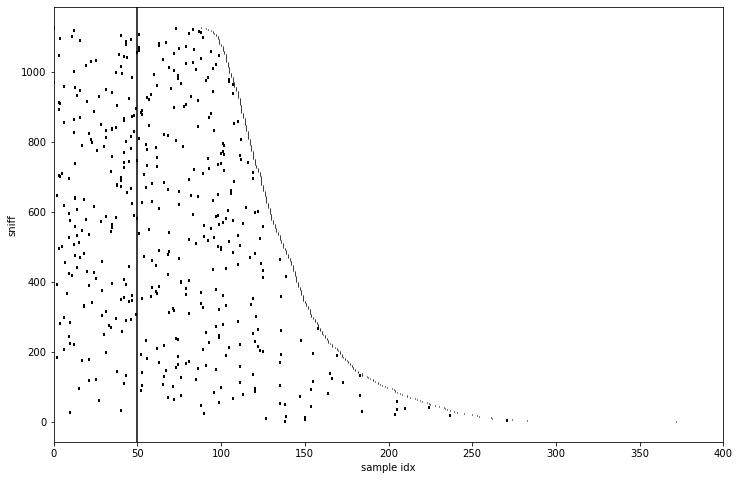

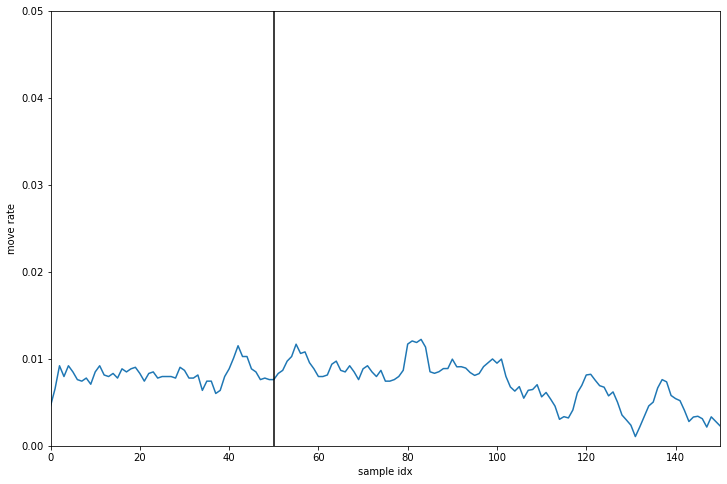

In [9]:
plot_sniff_multitrial(sniff_trial_first_sorted_valid_full)

In [10]:
# plot_sniff_multitrial_warp(sniff_trial_first_sorted_valid_full)

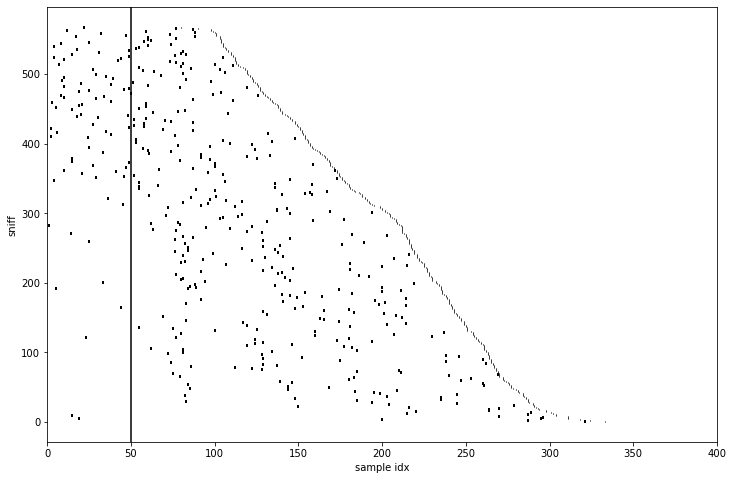

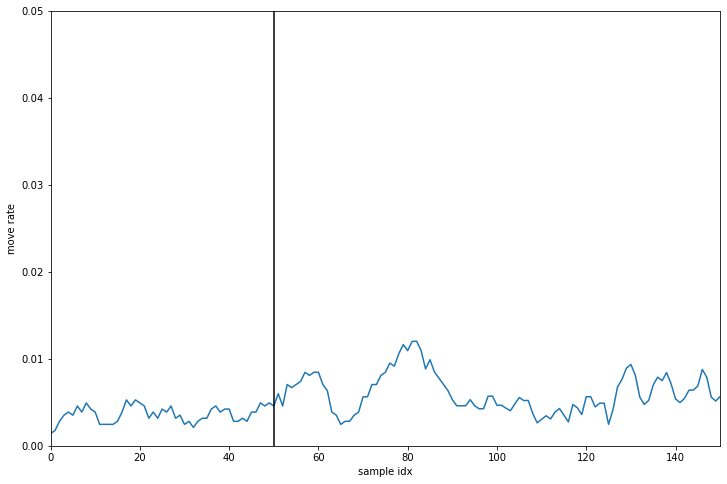

In [11]:
plot_sniff_multitrial(sniff_trial_after_sorted_valid_full)